In [ ]:
#|default_exp multispectral

In [ ]:
#| export
from __future__ import annotations

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Callable
from dataclasses import dataclass
from fastai.vision.all import *

from fastgs.vision.core import *
from fastgs.vision.augment import *
from fastgs.vision.learner import *
from fastgs.vision.load import *

# High level wrappers

> High level API to fastgs functionality

Sentinel 2 images consist of 13 raw bands, with pixel resolution ranging from 10m to 20m to 60m. In practice, we may be working with a subset of these bands.

For example we may choose to only work with the 10m resolution bands IR, R, G, B with corresponding band ids "B08", "B04", "B03", "B02". 

If we create an input tensor of such images the tensor indices of the image data for each band will be 0, 1, 2, 3 (for dimension 0) respectively.

#| hide

## `BandInputs` support class

To do this we need a helper class that maps channel names to channel indexes.

In [ ]:
#| hide
#| export
@dataclass
class BandInputs:
    ids: list[str]
    idxs: list[int]

    @classmethod
    def from_ids(cls, ids: list[str]):
        return cls(ids, [i for i in range(len(ids))])

#| hide
Map the the channels "B01", "B02", "B03" to 0, 1, 2

In [ ]:
#| hide
bands = BandInputs.from_ids(["B01","B02","B03"])

test_eq(bands, BandInputs(ids=["B01","B02","B03"], idxs=[0,1,2]))

#| hide
The following method returns the index corresponding to a channel name

In [ ]:
#| hide
#| export
@patch
def _get_index(self: BandInputs, id: str) -> int:
    return self.idxs[self.ids.index(id)]

In [ ]:
#| hide
test_eq(bands._get_index("B02"), 1)

#| hide
Return index tuples corresponding to a list of channel names.

In [ ]:
#| hide
#| export
@patch
def _get_bands(self: BandInputs, ids: list[str]) -> tuple[int]:
    assert set(ids).issubset(set(self.ids))
    return tuple(self._get_index(id) for id in ids)

In [ ]:
#| hide
test_eq(bands._get_bands(["B03","B01"]), (2, 0))

#| hide
Return list of index tuples corresponding to a list of lists of index channel names.

In [ ]:
#| hide
#| export
@patch
def get_bands_list(self: BandInputs, ids_list: list[list[str]]) -> list[tuple[int]]:
    return [self._get_bands(ids) for ids in ids_list]

In [ ]:
#| hide
test_eq(
    bands.get_bands_list([["B03","B02","B01"], ["B01"], ["B03"]]),
    [(2, 1, 0), (0,), (2,)],
)

#| hide
Return list of image captions corresponding to a list of lists of index channel names.

In [ ]:
#| hide
#| export
@patch
def get_captions(self: BandInputs, ids_list: list[list[str]]) -> list[tuple[int]]:
    return [','.join(ids) for ids in ids_list]

In [ ]:
bands.get_captions([["B03","B02","B01"], ["B01"], ["B03"]]),
    

(['B03,B02,B01', 'B01', 'B03'],)

In [ ]:
#| hide
test_eq(
    bands.get_captions([["B03","B02","B01"], ["B01"], ["B03"]]),
    ['B03,B02,B01', 'B01', 'B03'],
)

## `MSDescriptor`

We need a class that provides basic information about all the channels in the source data. The initial fields are based on the requirements of Sentinel2 images.

In [ ]:
#| export
class MSDescriptor:
    pass

In [ ]:
#| export
@patch
def __init__(self: MSDescriptor, band_ids, brgtX, res_m, rgb_combo): store_attr()

We use factories to create sensible defaults

In [ ]:
#| export
@patch(cls_method=True)
def from_all(
    cls: MSDescriptor,
    band_ids: tuple(str),
    brgtX: list(float),
    res_m: list[int],
    rgb_combo: dict[str, list[str]]={}
):
    return cls(band_ids,brgtX,res_m,rgb_combo)

@patch(cls_method=True)
def from_band_brgt(cls: MSDescriptor, band_ids: tuple(str), brgtX: list[int]):
    return cls.from_all(band_ids,brgtX,[None]*len(band_ids))

@patch(cls_method=True)
def from_bands(cls: MSDescriptor, band_ids: tuple(str)):
    return cls.from_band_brgt(band_ids,[1.0]*len(band_ids))

In [ ]:
@patch
def num_bands(self: MSDescriptor) -> int:
    return len(self.band_ids)

In [ ]:
test_eq(MSDescriptor.from_bands(["B0"]).num_bands(),1)

The list of 'raw' bands for sentinel 2 images is "B01","B02","B03","B04","B05","B06","B07","B08","B8A", "B09","B10","B11","B12","AOT"]

As described [here](07a_vision.core.ipynb#Image-Brightening), these images are naturall "dark" and we allow them to be brightened for display by providing a list of brightening multipliers. For this factory, I have selected values that seem to work well with our data, but it is by no means authoritative.

The third parameter is a list of the resolution of each raw band.

Finally we provide some named groups of 3 bands each, that have been found useful in providing [false color images for different applications](https://gisgeography.com/sentinel-2-bands-combinations/). The goal is to create (multiple) RGB images, corresponding to such sets of bands, for each multi-spectral tensor.

In [ ]:
#| export
def createSentinel2Descriptor() -> MSDescriptor:
    return MSDescriptor.from_all(
        ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12","AOT"],
        [2.5,4.75,4.25,3.75,3,2,1.7,1.7,2.5,2.5,1.6,1.6,2.2,30],
        [60,10,10,10,20,20,20,10,20,60,60,20,20,20],
        {# https://gisgeography.com/sentinel-2-bands-combinations/
            "natural_color": ["B04","B03","B02"],
            "color_infrared": ["B08","B04","B03"],
            "short_wave_infrared": ["B12","B8a","B04"],
            "agriculture": ["B11","B08","B02"],
            "geology": ["B12","B11","B02"],
            "bathymetric": ["B04","B03","B01"]
        }
    )

In [ ]:
sentinel2 = createSentinel2Descriptor()

This method lists all bands of a given resolution.

In [ ]:
#| export
@patch
def get_res_ids(self: MSDescriptor, res: int) -> list[str]:
    indices = [i for i,r in enumerate(self.res_m) if r == res]
    return [self.band_ids[i] for i in indices]

In [ ]:
test_eq(sentinel2.get_res_ids(10),["B02","B03","B04","B08"])

We can find the brightness multipliers corresponding to a list of channel names with this

In [ ]:
#| export
@patch
def get_brgtX(self: MSDescriptor, ids: list[str]) -> list[float]:
    indices = [self.band_ids.index(id) for id in ids]
    return [self.brgtX[i] for i in indices]

In [ ]:
test_eq(sentinel2.get_brgtX(["B8A","B01"]), [2.5,2.5])
test_eq(sentinel2.get_brgtX(sentinel2.rgb_combo["natural_color"]), [3.75,4.25,4.75])

... and so also the brightness value lists corresponding to name lists

In [ ]:
#| export
@patch
def get_brgtX_list(self: MSDescriptor, ids_list: list[list[str]]) -> list[list[float]]:
    return [self.get_brgtX(ids) for ids in ids_list]

In [ ]:
test_eq(
    sentinel2.get_brgtX_list([sentinel2.rgb_combo["color_infrared"],["B12","B11"]]), 
    [[1.7,3.75,4.25],[2.2,1.6]]
)

## `MSData`

We then create a `MSData` wrapper class which takes parameters that specifiy how to load the multi spectral image into a `TensorImageMS` object.

In [ ]:
#| export
class MSData:
    pass

In [ ]:
#| export
@patch
def __init__(
    self: MSData,
    ms_descriptor: MSDescriptor,
    bands: BandInputs,
    chn_grp_ids: list[list[str]],
    tensor_getter: MSTensorGetter
):
    store_attr()

In [ ]:
#| export
@patch(cls_method=True)
def from_files(
    cls: MSData,
    ms_descriptor: MSDescriptor,
    band_ids: list[str],
    chn_grp_ids: list[list[str]],
    files_getter: Callable[[list[str], Any], list[str]],
    chan_io_fn: Callable[[list[str]], Tensor]
):
    tensor_getter = MSTensorGetter.from_files(files_getter,chan_io_fn)
    return cls(ms_descriptor,BandInputs.from_ids(band_ids),chn_grp_ids,tensor_getter)

@patch(cls_method=True)
def from_loader(
    cls: MSData,
    ms_descriptor: MSDescriptor,
    band_ids: list[str],
    chn_grp_ids: list[list[str]],
    tg_fn: Callable[[list[str], Any], Tensor]
):
    tensor_getter = MSTensorGetter.from_delegate(tg_fn)
    return cls(ms_descriptor,BandInputs.from_ids(band_ids),chn_grp_ids,tensor_getter)

In [ ]:
from fastgs.test.io import *

In [ ]:
def get_input(stem: str) -> str:
    "Get full input path for stem"
    return "./images/" + stem

def tile_img_name(chn_id: str, tile_num: int) -> str:
    "File name from channel id and tile number"
    return f"Sentinel20m-{chn_id}-20200215-{tile_num:03d}.png"

def get_channel_filenames(chn_ids, tile_idx):
    "Get list of all channel filenames for one tile idx"
    return [get_input(tile_img_name(x, tile_idx)) for x in chn_ids]

seg_codes = ["not-cloudy","cloudt"] 

We can create a sentinel data loader for only the RGB channels

In [ ]:
rgb_bands = MSData.from_files(
    sentinel2,
    ["B02","B03","B04"],
    [sentinel2.rgb_combo["natural_color"]],
    get_channel_filenames,
    read_multichan_files
)

where `read_multichan_files_as_tensor` is defined [here](000_test.io.ipynb)

or we might choose to only look at the 10m resolution bands 

In [ ]:
tenm_bands = MSData.from_files(
    sentinel2,
    sentinel2.get_res_ids(10),
    [sentinel2.rgb_combo["natural_color"], ["B08"]],
    get_channel_filenames,
    read_multichan_files
)

or even 11 channels of sentinel 2 data

In [ ]:
elvn_bands = MSData.from_files(
    sentinel2,
    ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12","AOT"],
    [sentinel2.rgb_combo["natural_color"], ["B07","B06","B05"],["B12","B11","B8A"],["B08"]],
    get_channel_filenames,
    read_multichan_files
)

In [ ]:
#| export
@patch
def _load_image(self: MSData, img_id, cls: TensorImage) -> TensorImage:
    ids_list = self.chn_grp_ids
    bands = self.bands.get_bands_list(ids_list)
    captions = self.bands.get_captions(ids_list)
    brgtX = self.ms_descriptor.get_brgtX_list(ids_list)
    return cls(self.tensor_getter.load_tensor(self.bands.ids, img_id), bands=bands, captions=captions, brgtX=brgtX)

@patch
def load_image(self: MSData, img_id) -> TensorImageMS:
    return self._load_image(img_id, TensorImageMS)                

In [ ]:
#| export
@patch
def num_channels(self: MSData) -> int:
    return len(self.bands.ids)

[<AxesSubplot: title={'center': 'B04,B03,B02'}>]

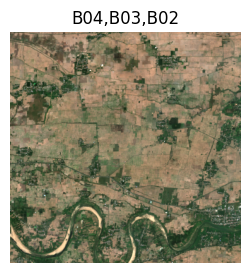

In [ ]:
rgb_tensor = rgb_bands.load_image(66)
test_eq(rgb_bands.num_channels(),3)
rgb_tensor.show()

[<AxesSubplot: title={'center': 'B04,B03,B02'}>,
 <AxesSubplot: title={'center': 'B08'}>]

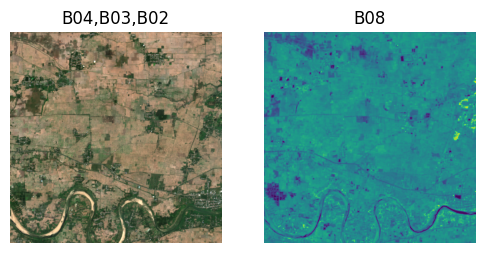

In [ ]:
tenm_tensor = tenm_bands.load_image(66)
test_eq(tenm_bands.num_channels(),4)
tenm_tensor.show()

[<AxesSubplot: title={'center': 'B04,B03,B02'}>,
 <AxesSubplot: title={'center': 'B07,B06,B05'}>,
 <AxesSubplot: title={'center': 'B12,B11,B8A'}>,
 <AxesSubplot: title={'center': 'B08'}>]

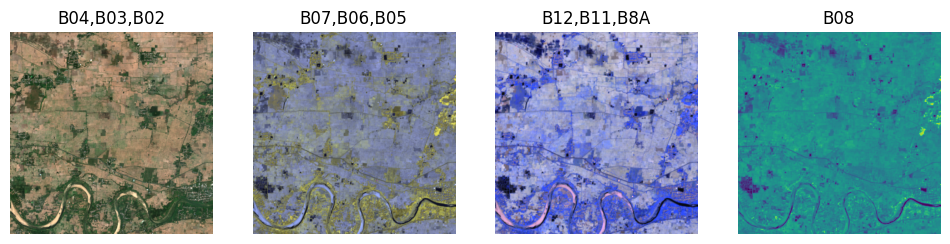

In [ ]:
elvn_tensor = elvn_bands.load_image(66)
test_eq(elvn_bands.num_channels(),11)
elvn_tensor.show()

## `MaskData`

Finally, for convenience, we provide a wrapper class to load mask data

In [ ]:
#| export
class MaskData:
    pass

In [ ]:
#| export
@patch
def __init__(
    self: MaskData,
    mask_id: str,
    mask_getter: Callable[[list[str], Any], TensorMask],
    mask_codes: list[str]
):
    store_attr()

In [ ]:
#| export
@patch
def load_mask(self: MaskData, img_id) -> TensorMask:
    return self.mask_getter.load_mask(self.mask_id, img_id)

In [ ]:
#| export
@patch
def num_channels(self: MaskData) -> int:
    return len(self.mask_codes)

In [ ]:
#| export
@patch(cls_method=True)
def from_files(
    cls: MaskData,
    mask_id: str,
    files_getter: Callable[[list[str], Any], list[str]],
    mask_io_fn: Callable[[list[str]], Tensor],
    mask_codes: list[str]
):
    mask_getter = MSMaskGetter.from_files(files_getter,mask_io_fn)
    return cls(mask_id,mask_getter,mask_codes)

@patch(cls_method=True)
def from_loader(
    cls: MaskData,
    mask_id: str,
    tg_fn: Callable[[list[str], Any], Tensor],
    mask_codes: list[str]
):
    mask_getter = MSMaskGetter.from_delegate(tg_fn)
    return cls(mask_id,mask_getter,mask_codes)

<AxesSubplot: >

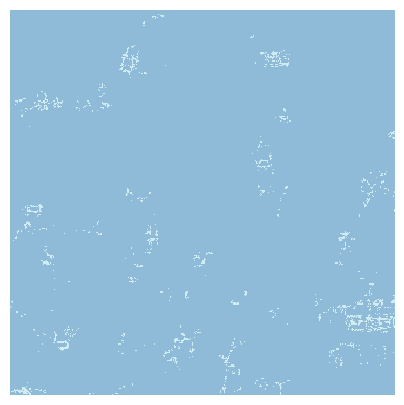

In [ ]:
masks = MaskData.from_files("LC",get_channel_filenames,read_mask_file,["non-building","building"])
test_eq(masks.num_channels(),2)
mask = masks.load_mask(66)
mask.show()

# `MSAugment`

A wrapper class for augmentations

In [ ]:
#| export
class MSAugment:
    pass

In [ ]:
#| export
@patch
def __init__(self: MSAugment,train_aug=None,valid_aug=None): store_attr()

## Transforms

Next we create the various transforms required for the fastai pipeline

In [ ]:
#| export
@patch
def create_xform_block(self: MSData) -> DataBlock:
    return TransformBlock(type_tfms=[
            partial(MSData.load_image,self),
        ])

In [ ]:
#| export
@patch
def create_xform_block(self: MaskData) -> DataBlock:
    return TransformBlock(type_tfms=[
            partial(MaskData.load_mask,self),
            AddMaskCodes(codes=self.mask_codes),
        ])

In [ ]:
#| export
@patch
def create_item_xforms(self: MSAugment) -> list(ItemTransform):
    if self.train_aug is None and self.valid_aug is None: return []
    elif self.valid_aug is None: return [TrainMSSAT(self.train_aug)]
    elif self.train_aug is None: return [ValidMSSAT(self.valid_aug)]
    else: return [TrainMSSAT(self.train_aug),ValidMSSAT(self.valid_aug)]

## `GSModel`

We create a wrapper class the encapsulates the model we use

In [ ]:
#| export
class GSModel:
    def create_learner(self, dl, pretrained=False, **kwargs):
        pass
    def load_learner(self,model_path,dl):
        pass

In [ ]:
#| export
@patch
def __init__(self: GSModel, model, n_in, n_out, loss_func, metrics):
    store_attr()

@patch(cls_method=True)
def from_all(
    cls:GSModel,
    model,
    ms_data:MSData,
    mask_codes:[str],
    loss_func=CrossEntropyLossFlat(axis=1),
    metrics=Dice(axis=1)
):
    return cls(model,len(ms_data.bands.ids),len(mask_codes),loss_func,metrics)

In [ ]:
#| export
class GSUnetModel(GSModel):
    pass

@patch
def create_learner(self:GSUnetModel,dl,pretrained=False,**kwargs):
    learner = unet_learner(dl,self.model,n_in=self.n_in,n_out=self.n_out,pretrained=pretrained,loss_func=self.loss_func,metrics=self.metrics)
    if pretrained:
        learner.model[0][0].fastgs_reinit_weights(reweight=reweight)
    return learner

@patch
def load_learner(self:GSUnetModel,model_path:str,dl):
    learner = unet_learner(dl,self.model,n_in=self.n_in,n_out=self.n_out,pretrained=False,loss_func=self.loss_func,metrics=self.metrics)
    learner.load(model_path)
    return learner

## `FastGS`

Finally we have a **master** wrapper class which provides the high level api to create fastai datablocks and learners.

In [ ]:
#| export
class FastGS:
    pass

In [ ]:
#| export
@patch
def __init__(self:FastGS, model:GSModel, ms_data:MSData, mask_data:MaskData, ms_aug:MSAugment):
    store_attr()

In [ ]:
#| export
@patch(cls_method=True)
def for_training(
    cls:FastGS,
    ms_data:MSData,
    mask_data:MaskData,
    ms_aug:MSAugment=MSAugment()
):
    model = GSUnetModel.from_all(resnet18,ms_data,mask_data.mask_codes)
    return cls(model,ms_data,mask_data,ms_aug)

@patch(cls_method=True)
def for_inference(
    cls:FastGS,
    ms_data:MSData,
    mask_codes:[str]
):
    model = GSUnetModel.from_all(resnet18,ms_data,mask_codes)
    return cls(model,ms_data,None,None)

In [ ]:
fgs = FastGS.for_training(elvn_bands,masks)

In [ ]:
#| export
@patch
def create_data_block(self: FastGS, splitter=RandomSplitter(valid_pct=0.2, seed=107)) -> DataBlock:
    return DataBlock(
        blocks=(self.ms_data.create_xform_block(),self.mask_data.create_xform_block()),
        splitter=splitter,
        item_tfms=self.ms_aug.create_item_xforms()
    )

In [ ]:
db = fgs.create_data_block()
dl = db.dataloaders([66]*10,bs=8)

In [ ]:
#| export
@patch
def create_learner(self:FastGS,dl,reweight="avg") -> Learner:
    return self.model.create_learner(dl,pretrained=reweight is None,reweight=reweight)

@patch
def load_learner(self:FastGS,model_path,dl) -> Learner:
    return self.model.load_learner(model_path,dl)

In [ ]:
#| notest
learner = fgs.create_learner(dl,resnet18)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()